## Libraries to import

In [68]:
!pip install tensorflow
!pip install -q -U keras-tuner

In [69]:
from google.colab import drive
drive.mount('/content/drive')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing the dataset

In [70]:
all_prices = pd.read_csv('/content/drive/MyDrive/ml-datasets/currencies_prediction/prices_30m.csv')

### Feature engineering

In [71]:
# adding features that make more sense than raw data
# all_prices["Gold_ret"] = all_prices["Gold"].pct_change()
# all_prices["Silver_ret"] = all_prices["Silver"].pct_change()
# all_prices["CAD_ret"] = all_prices["CAD"].pct_change()

# all_prices["Gold_ma"] = all_prices["Gold"].rolling(5).mean()
# all_prices["Silver_ma"] = all_prices["Silver"].rolling(5).mean()
# all_prices["CAD_ma"] = all_prices["CAD"].rolling(5).mean()

In [72]:
all_prices = all_prices.dropna().drop(columns=['Datetime'])

In [73]:
all_prices.head()

,Gold,Silver,CAD
0,3868.0,46.805,0.716214
1,3868.0,46.805,0.716286
2,3868.0,46.805,0.716132
3,3868.0,46.805,0.716112
4,3868.0,46.805,0.716014


In [74]:
all_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1977 entries, 0 to 1976
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Gold    1977 non-null   float64
 1   Silver  1977 non-null   float64
 2   CAD     1977 non-null   float64
dtypes: float64(3)
memory usage: 46.5 KB


In [75]:
all_prices.describe()

,Gold,Silver,CAD
count,1977.000000,1977.000000,1977.000000
mean,4093.382450,49.802239,0.713104
std,103.968394,2.155685,0.002500
min,3867.199951,45.665001,0.707269
25%,4012.000000,48.125000,0.711744
50%,4078.199951,49.410000,0.713084
75%,4162.899902,51.130001,0.714725
max,4394.299805,58.564999,0.719746


In [76]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(all_prices)
scaled

array([[0.00151783, 0.08837206, 0.71698483],
       [0.00151783, 0.08837206, 0.72274134],
       [0.00151783, 0.08837206, 0.71041141],
       ...,
       [0.77139056, 0.95232574, 0.68124188],
       [0.77271896, 0.94922489, 0.68124188],
       [0.784102  , 0.94844983, 0.68124188]])

In [77]:
def create_sequences(data, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i : i + timesteps])
        y.append(data[i + timesteps])
    return np.array(X), np.array(y)

In [78]:
max_window = 60

X, y = create_sequences(scaled, max_window)
X.shape

(1917, 60, 3)

### Train/test split

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)

## GRU implementation

### Hyperparameter tuning

In [80]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

def mae(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

def mape(y_true, y_pred):
    return tf.reduce_mean(tf.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

In [81]:
def model_builder(hp):
    model = keras.Sequential([
        keras.layers.GRU(
            units=hp.Int("units_1", min_value=16, max_value=128, step=16),
            return_sequences=True,
            input_shape=(hp.Int("window", min_value=10, max_value=100, step=10), 3),
            kernel_regularizer=keras.regularizers.l2(hp.Choice("l2_reg", values=[1e-6, 1e-5, 1e-4]))
        ),
        keras.layers.Dropout(hp.Float("dropout_1", min_value=0.1, max_value=0.3, step=0.05)),
        keras.layers.GRU(
            units=hp.Int("units_2", min_value=8, max_value=64, step=8),
            return_sequences=False,
            kernel_regularizer=keras.regularizers.l2(hp.Choice("l2_reg2", [1e-6, 1e-5, 1e-4])),
        ),
        keras.layers.Dropout(hp.Float("dropout_2", min_value=0.1, max_value=0.3, step=0.05)),
        keras.layers.Dense(3, activation="relu") #output
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1e-2, 5e-3, 1e-3, 5e-4, 1e-4])),\
        loss="mse",
        metrics=[rmse, mae, mape]
    )

    return model

In [82]:
tuner = kt.Hyperband(
    model_builder,
    objective=kt.Objective("val_rmse", direction="min"),
    max_epochs=40,
    max_consecutive_failed_trials=5,
    seed=42,
    directory="tuning_results",
    project_name="gold_silver_cad",
)

Reloading Tuner from tuning_results/gold_silver_cad/tuner0.json


In [83]:
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5
)

In [84]:
tuner.search(x=X_train, y=y_train, validation_split=0.15, callbacks=[stop_early])

Trial 87 Complete [00h 02m 29s]
val_rmse: 0.05844685062766075

Best val_rmse So Far: 0.01888570375740528
Total elapsed time: 01h 44m 11s


### Metrics evaluation of the best model

In [86]:
best_model = tuner.get_best_models(1)[0]
best_model.save('gru_30m.keras')
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 80, 112)        │        39,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 80, 112)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        34,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,683 (287.82 KB)

 Trainable params: 73,683 (287.82 KB)

 Non-trainable params: 0 (0.00 B)

In [87]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values

{'units_1': 112,
 'window': 80,
 'l2_reg': 1e-05,
 'dropout_1': 0.1,
 'learning_rate': 0.005,
 'units_2': 64,
 'l2_reg2': 1e-06,
 'dropout_2': 0.25,
 'tuner/epochs': 40,
 'tuner/initial_epoch': 14,
 'tuner/bracket': 3,
 'tuner/round': 3,
 'tuner/trial_id': '0045'}

In [88]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

model = best_model

y_pred = model.predict(X_test)

y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

rmse_val = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae_val  = mean_absolute_error(y_test_inv, y_pred_inv)
mape_val = mean_absolute_percentage_error(y_test_inv, y_pred_inv)

print("RMSE:", rmse_val)
print("MAE :", mae_val)
print("MAPE:", mape_val)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
RMSE: 8.361919700830407
MAE : 4.017897104637491
MAPE: 0.0028908187464457614


In [89]:
baseline = scaler.inverse_transform(X_test[:, -1, :])

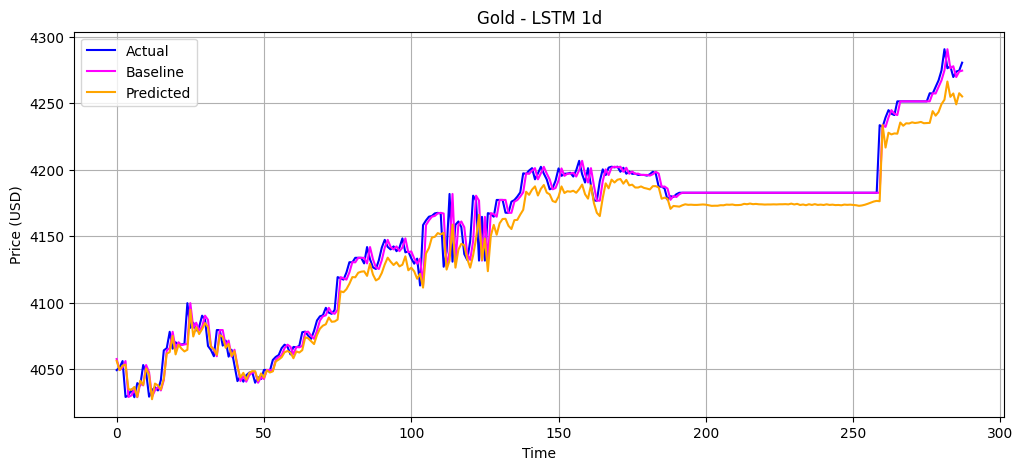

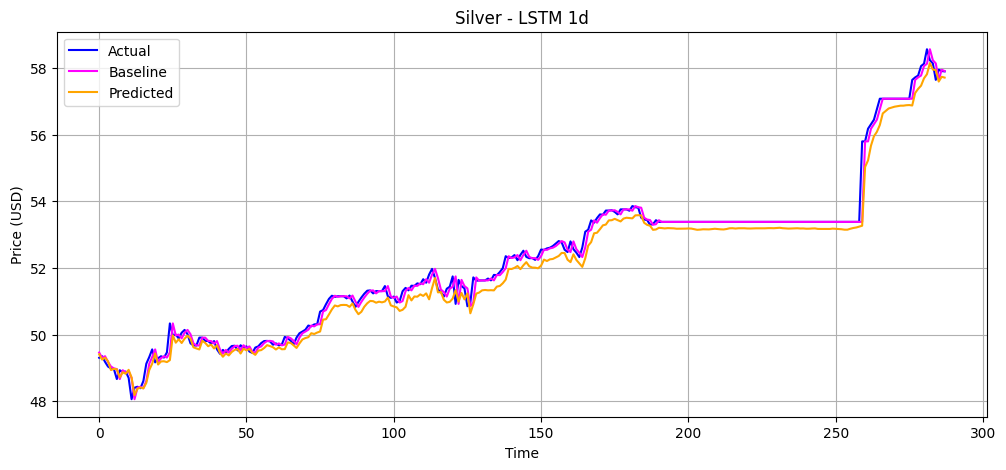

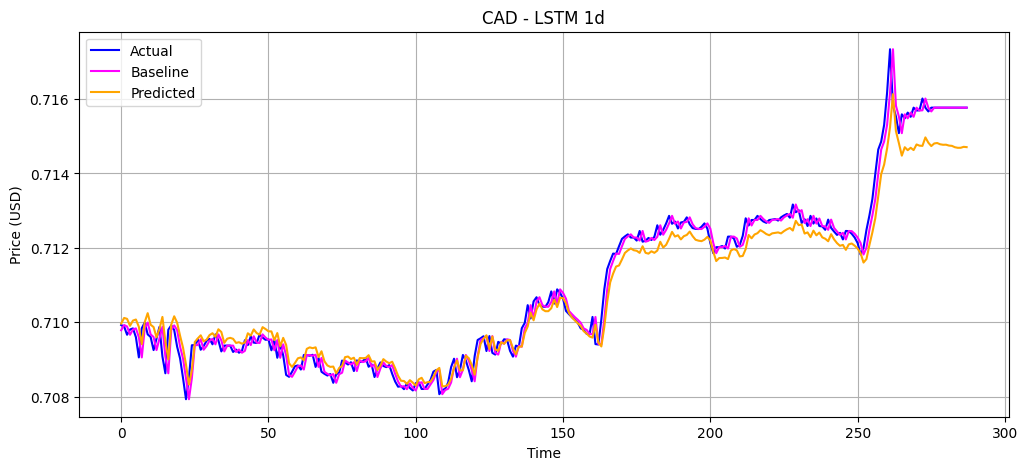

In [92]:
def plot_asset(i, asset_name):
    plt.figure(figsize=(12,5))
    plt.plot(y_test_inv[:, i], label="Actual", color="blue")
    plt.plot(baseline[:, i], label="Baseline", color="magenta")
    plt.plot(y_pred_inv[:, i], label="Predicted", color="orange")
    plt.title(f"{asset_name} - GRU 1d")
    plt.xlabel("Time")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_asset(0, "Gold")
plot_asset(1, "Silver")
plot_asset(2, "CAD")

In [91]:
def mae(y, p): return np.mean(np.abs(y-p))
def rmse(y, p): return np.sqrt(np.mean((y-p)**2))
def mape(y, p): return np.mean(np.abs((y-p)/y))*100

assets = ["Gold","Silver","CAD"]
for i in range(3):
    print(assets[i])
    print(" MAE :", mae(y_test_inv[:,i], y_pred_inv[:,i]))
    print(" RMSE:", rmse(y_test_inv[:,i], y_pred_inv[:,i]))
    print(" MAPE:", mape(y_test_inv[:,i], y_pred_inv[:,i]))
    print()

Gold
 MAE : 11.773379855685766
 RMSE: 14.47891649613562
 MAPE: 0.2823840385222284

Silver
 MAE : 0.27993426058027454
 RMSE: 0.35507760039680486
 MAPE: 0.5318953326281447

CAD
 MAE : 0.0003771976464324527
 RMSE: 0.0004950104778956928
 MAPE: 0.052966252783355865



### Retrain a model with best HPs 10 times

To ensure the model did not randomly achieve good results with the test set

In [ ]:
mae_arr = []
rmse_arr = []
mape_arr = []

for i in range(10):

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)

  model = keras.Sequential([
      keras.layers.GRU(
          units=best_hps.values["units_1"],
          return_sequences=True,
          input_shape=(best_hps.values["window"], 3),
          kernel_regularizer=best_hps.values["l2_reg"]
      ),
      keras.layers.Dropout(best_hps.values["dropout_1"]),
      keras.layers.GRU(
          units=best_hps.values["units_2"],
          return_sequences=False,
          kernel_regularizer=best_hps.values["l2_reg"],
      ),
      keras.layers.Dropout(best_hps.values["dropout_2"]),
      keras.layers.Dense(3, activation="relu") #output
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(best_hps.values["learning_rate"]),
      loss='mse',
      metrics=[rmse, mae, mape]
  )

  model.fit(X_train, y_train, epochs=best_hps.values['tuner/epochs'])

  y_pred = model.predict(X_test)

  y_pred_inv = scaler.inverse_transform(y_pred)
  y_test_inv = scaler.inverse_transform(y_test)

  rmse_val = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
  mae_val  = mean_absolute_error(y_test_inv, y_pred_inv)
  mape_val = mean_absolute_percentage_error(y_test_inv, y_pred_inv)

  print("RMSE:", rmse_val)
  print("MAE :", mae_val)
  print("MAPE:", mape_val)